In [1]:
import gym
import matplotlib.pyplot as plt
import pyglet

Everything taken from [Getting Started With OpenAI Gym: The Basic Building Blocks](https://blog.paperspace.com/getting-started-with-openai-gym/).

In [2]:
env = gym.make('MountainCar-v0')

C:\Users\filre\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
# Observation and action space
# The observation for this is a vector of two numbers representing velocity and position.
obs_space = env.observation_space
action_space = env.action_space
print("The observation space: {}".format(obs_space))
print("The action space: {}".format(action_space))

The observation space: Box(2,)
The action space: Discrete(3)


- ```reset```: This function resets the environment to its initial state, and returns the observation of the environment corresponding to the initial state.
- ```step```: This function takes an action as an input and applies it to the environment, which leads to the environment transitioning to a new state. The reset function returns four things:

1. ```observation```: The observation of the state of the environment.
2. ```reward```: The reward that you can get from the environment after executing the action that was given as the input to the step function.
3. ```done```: Whether the episode has been terminated. If true, you may need to end the simulation or reset the environment to restart the episode.
4. ```info```: This provides additional information depending on the environment, such as number of lives left, or general information that may be conducive in debugging.

In [4]:
# reset the environment and see the initial observation
obs = env.reset()
print("The initial observation is {}".format(obs))

# Sample a random action from the entire action space
random_action = env.action_space.sample()

# # Take the action and get the new observation space
new_obs, reward, done, info = env.step(random_action)
print("The new observation is {}".format(new_obs))

The initial observation is [-0.41452831  0.        ]
The new observation is [-4.14331822e-01  1.96490936e-04]


Often the observation is a screenshot of the game, here however it is not.

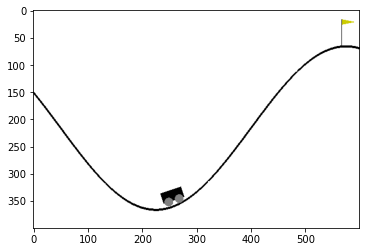

In [5]:
# used to make the environment visible
#env.render(mode = "human") # to open a popup window
screenshot = env.render(mode = "rgb_array")
plt.imshow(screenshot) # to print image
env.close()

In [6]:
import time

# Number of steps you run the agent for
num_steps = 0

obs = env.reset()

for step in range(num_steps):
    # take random action, but you can also do something more intelligent
    # action = my_intelligent_agent_fn(obs)
    action = env.action_space.sample()

    # apply the action
    obs, reward, done, info = env.step(action)

    # Render the env
    env.render()

    # Wait a bit before the next frame unless you want to see a crazy fast video
    frame_time = 1/60 # 1 frame at 60 fps
    time.sleep(frame_time)

    # If the epsiode is up, then start another one
    if done:
        env.reset()

# Close the env
env.close()

```Box(n,)``` corresponds to the n-dimensional continuous space.

Of course, the space is bounded by upper and lower limits which describe the legitimate values our observations can take. We can determine this using the ```high``` and ```low``` attributes of the observation space.

In [7]:
print("Upper Bound for Env Observation", env.observation_space.high)
print("Lower Bound for Env Observation", env.observation_space.low)

Upper Bound for Env Observation [0.6  0.07]
Lower Bound for Env Observation [-1.2  -0.07]


The ```Discrete(n)``` box describes a discrete space with ```[0.....n-1]``` possible values. In our case ```n = 3```, meaning our actions can take values of either 0, 1, or 2. Unlike ```Box```, ```Discrete``` does not have a ```high``` and ```low``` method, since, by the very definition, it is clear what type of values are allowed.

In [8]:
# Works
env.step(2)
print("It works!")

# Doesn't work.
#env.step(4)
#print("It works!")
# invalid actions cause errors

It works!


In [9]:
import gym

In [10]:
env = gym.make("BreakoutNoFrameskip-v4")

print("Observation Space: Box", env.observation_space.shape)
print("Action Space       ", env.action_space)


obs = env.reset()

for i in range(1000):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    env.render()
    time.sleep(0.01)
env.close()

Observation Space: Box (210, 160, 3)
Action Space        Discrete(4)


Our observation space is a continuous space of dimensions (210, 160, 3) corresponding to an RGB pixel observation of the same size. Our action space  contains 4 discrete actions (Left, Right, Do Nothing, Fire)

### Using Wrapper
 Let us suppose we have to make certain changes to the Atari Environment. It's a common practice in Deep RL that we construct our observation by concatenating the past ```k``` frames together. We have to modify the Breakout Environment such that both our ```reset``` and ```step``` functions return concatenated observations.

For this we define a class of type ```gym.Wrapper``` to override the ```reset``` and ```return``` functions of the Breakout ```Env```. The ```Wrapper``` class, as the name suggests, is a wrapper on top of an ```Env``` class that modifies some of its attributes and functions.

The ```__init__``` function is defined with the ```Env``` class for which the wrapper is written, and the number of past frames to be concatenated. Note that we also need to redefine the observation space since we are now using concatenated frames as our observations. (We modify the observation space from (210, 160, 3) to (210, 160, 3 * num_past_frames.)

In the ```reset``` function, while we are initializing the environment, since we don't have any previous observations to concatenate, we concatenate just the initial observations repeatedly.

In [11]:
import gym
from gym import spaces
from collections import deque
import numpy as np

class ConcatObs(gym.Wrapper):
    def __init__(self, env, k):
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=((k,) + shp), dtype=env.observation_space.dtype)


def reset(self):
    ob = self.env.reset()
    for _ in range(self.k):
        self.frames.append(ob)
    return self._get_ob()

def step(self, action):
    ob, reward, done, info = self.env.step(action)
    self.frames.append(ob)
    return self._get_ob(), reward, done, info

def _get_ob(self):
    return np.array(self.frames)

In [12]:
env = gym.make("BreakoutNoFrameskip-v4")
wrapped_env = ConcatObs(env, 4)
print("The new observation space is Box", wrapped_env.observation_space.shape)

The new observation space is Box (4, 210, 160, 3)


There is more to Wrappers than the vanilla Wrapper class. Gym also provides you with specific wrappers that target specific elements of the environment, such as observations, rewards, and actions. Their use is demonstrated in the following section.

- ObservationWrapper: This helps us make changes to the observation using the observation method of the wrapper class.
- RewardWrapper: This helps us make changes to the reward using the reward function of the wrapper class.
- ActionWrapper: This helps us make changes to the action using the action function of the wrapper class.

### Vectorized Environments

The wrapper of interest here is called ```SubProcEnv```, which will run all the environments in an asynchronous method. We first create a list of function calls that return the environment we are running. In code, I have used a ```lambda``` function to create an anonymous function that returns the gym environment.

In [13]:
# get the neccasary stuff
import gym
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv

# list of envs
num_envs = 3
envs = [lambda: gym.make("BreakoutNoFrameskip-v4") for i in range(num_envs)]

# Vec Env
envs = SubprocVecEnv(envs)

This ```envs``` now acts as a single environment where we can call the ```reset``` and ```step``` functions. However, these functions return an array of observations/actions now, rather than a single observation/action.

In [15]:
# Get initial state
init_obs = envs.reset()


# We get a list of observations corresponding to parallel environments
print("Number of Envs:", len(init_obs))

# Check out of the obs
one_obs = init_obs[0]
print("Shape of one Env:", one_obs.shape)

# prepare a list of actions and apply them to environment
actions = [0, 1, 2]
obs = envs.step(actions)

Number of Envs: 3
Shape of one Env: (210, 160, 3)


Calling the render function on the vectorized ```envs``` displays screenshots of the games in a tiled fashion.

In [17]:
# render the envs
import time

# list of envs
num_envs = 4
envs = [lambda: gym.make("BreakoutNoFrameskip-v4") for i in range(num_envs)]

# Vec Env
envs = SubprocVecEnv(envs)

init_obs = envs.reset()

for i in range(1000):
    actions = [envs.action_space.sample() for i in range(num_envs)]
    envs.step(actions)
    envs.render()
    time.sleep(0.001)

envs.close()